In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier,AdaBoostClassifier,VotingClassifier,StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import NuSVC,LinearSVC,SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectFromModel


from sklearn.feature_selection import RFE,RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,f1_score,precision_score,cohen_kappa_score,fbeta_score
from sklearn.metrics import RocCurveDisplay,roc_auc_score,accuracy_score,roc_curve,precision_recall_curve,log_loss,balanced_accuracy_score
from yellowbrick.classifier import ClassificationReport,ROCAUC,precision_recall_curve,class_prediction_error,ConfusionMatrix,roc_auc,PrecisionRecallCurve
from yellowbrick.model_selection import feature_importances,FeatureImportances

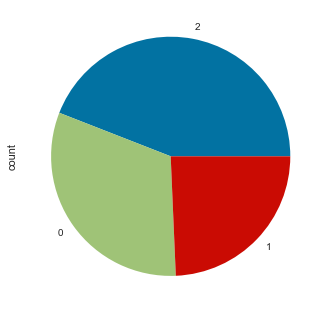

In [2]:
df = pd.read_csv('GPL6947.csv')
df.columns
df['Status'].value_counts()
# draw pie plot for status values
df['Status'].value_counts().plot.pie()
plt.show()


In [3]:
X=df.drop(['ID_REF','Status'],axis=1)
Y=df['Status']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=45)
print(Y_train.value_counts())
print('\n')
print(Y_test.value_counts())



Status
2    115
0     84
1     64
Name: count, dtype: int64


Status
2    30
0    20
1    16
Name: count, dtype: int64


In [4]:
rus= RandomOverSampler(random_state=42)
X_train_resampled,Y_train_resampled =rus.fit_resample(X_train,Y_train)

# create new Dataframe with undersampled data
df_resampled=pd.concat([X_train_resampled,Y_train_resampled],axis=1)
df_resampled['Status'].value_counts()

Status
1    115
2    115
0    115
Name: count, dtype: int64

<AxesSubplot:xlabel='Status', ylabel='count'>

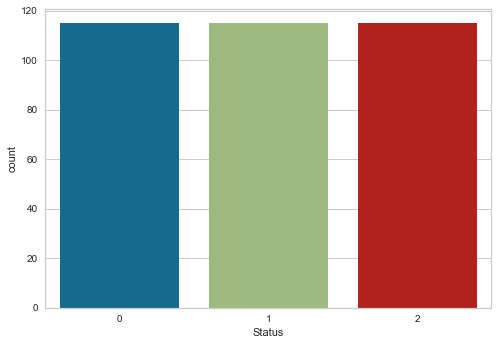

In [5]:
df_resampled['Status'].value_counts()
sns.countplot(df_resampled['Status'])

In [6]:
df_resampled

,LPP,HIC2,PITPNM1,DUS1L,BCL2L1,KDM6A,LRCH4,CHD1,CLC,TMED2,...,ADGRG1,FAM134B,FAM212B,FPR2,MBP,CLIP1,DHDDS,Age,Gender,Status
0,10.196056,8.087993,10.395106,8.372789,12.489462,8.200846,9.876242,8.159938,11.631995,8.922828,...,10.567284,7.884859,8.253161,9.618926,9.935077,8.486714,8.227674,71,1,1
1,10.924537,8.082808,10.455406,8.183647,12.428495,8.338555,9.978270,8.109667,12.245385,9.201759,...,11.418707,7.699999,9.016177,9.564263,10.000369,8.264852,8.180646,86,1,2
2,11.076907,8.234124,10.753207,7.872176,12.535970,8.169469,10.797449,8.266736,10.758501,9.267145,...,10.794888,7.814875,8.768869,10.507901,10.759832,8.915538,8.165619,83,1,2
3,10.096571,8.039319,10.759832,8.143964,12.780702,8.095643,10.774347,8.158365,11.192886,8.451277,...,10.842074,7.672215,9.353748,9.604805,9.915660,8.111318,8.419288,66,1,1
4,10.600872,8.127782,10.650823,8.071683,11.774898,8.404755,10.131151,8.124449,10.363076,9.041828,...,11.634304,7.902012,9.361623,10.722473,10.146521,8.703126,7.860785,79,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,10.840700,8.116907,10.371316,7.909760,12.824991,8.219540,9.765418,8.371249,11.436909,9.210116,...,11.622746,7.923192,9.348325,10.217470,10.946598,8.810404,8.100571,71,1,1
341,10.988956,8.120050,10.524136,7.952259,11.485381,8.083385,10.227713,8.802742,10.662019,9.158187,...,10.547112,8.256183,9.006955,10.115124,10.345278,9.010124,7.960646,81,0,1
342,10.793589,8.127942,10.492161,7.913203,12.608218,8.314625,9.907574,8.329771,11.900524,9.088293,...,10.204515,8.289380,8.729749,10.085781,11.006047,8.472556,7.965396,87,1,1
343,10.701532,8.036958,10.369320,7.961668,13.930563,8.070339,9.654970,8.221847,10.853527,8.658755,...,10.455406,7.695600,9.404363,9.948981,10.968817,8.744278,8.169948,70,1,1


# feature selection using pearson method

In [7]:
num_feats=200
def cor_selector(X, Y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], Y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, Y,num_feats)
print(str(len(cor_feature)), 'selected features')

200 selected features


# feature selection using chi-square method

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X, Y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

200 selected features


# feature selection using RFE

# RFE_randomforest

In [9]:
# selection of features using RFE using randomforest


rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X, Y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 452 features.
Fitting estimator with 442 features.
Fitting estimator with 432 features.
Fitting estimator with 422 features.
Fitting estimator with 412 features.
Fitting estimator with 402 features.
Fitting estimator with 392 features.
Fitting estimator with 382 features.
Fitting estimator with 372 features.
Fitting estimator with 362 features.
Fitting estimator with 352 features.
Fitting estimator with 342 features.
Fitting estimator with 332 features.
Fitting estimator with 322 features.
Fitting estimator with 312 features.
Fitting estimator with 302 features.
Fitting estimator with 292 features.
Fitting estimator with 282 features.
Fitting estimator with 272 features.
Fitting estimator with 262 features.
Fitting estimator with 252 features.
Fitting estimator with 242 features.
Fitting estimator with 232 features.
Fitting estimator with 222 features.
Fitting estimator with 212 features.
Fitting estimator with 202 features.
200 selected features



# RFE_SVC

In [10]:
# selection of features using RFE using svc


rfe_selector_svc = RFE(estimator=SVC(kernel='linear'), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector_svc.fit(X, Y)
rfe_support_svc = rfe_selector_svc.get_support()
rfe_feature_svc = X.loc[:,rfe_support_svc].columns.tolist()
print(str(len(rfe_feature_svc)), 'selected features')

Fitting estimator with 452 features.
Fitting estimator with 442 features.
Fitting estimator with 432 features.
Fitting estimator with 422 features.
Fitting estimator with 412 features.
Fitting estimator with 402 features.
Fitting estimator with 392 features.
Fitting estimator with 382 features.
Fitting estimator with 372 features.
Fitting estimator with 362 features.
Fitting estimator with 352 features.
Fitting estimator with 342 features.
Fitting estimator with 332 features.
Fitting estimator with 322 features.
Fitting estimator with 312 features.
Fitting estimator with 302 features.
Fitting estimator with 292 features.
Fitting estimator with 282 features.
Fitting estimator with 272 features.
Fitting estimator with 262 features.
Fitting estimator with 252 features.
Fitting estimator with 242 features.
Fitting estimator with 232 features.
Fitting estimator with 222 features.
Fitting estimator with 212 features.
Fitting estimator with 202 features.
200 selected features


# feature selection using embedded techinques

# embeded method using Random forest

In [11]:
# embeded feature selection using randomforest
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, Y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

158 selected features


# embeded method using SVC

In [12]:
# embeded feature selection using SVC
embeded_svc_selector = SelectFromModel(SVC(kernel='linear'), max_features=num_feats)
embeded_svc_selector.fit(X, Y)

embeded_svc_support = embeded_svc_selector.get_support()
embeded_svc_feature = X.loc[:,embeded_svc_support].columns.tolist()
print(str(len(embeded_svc_feature)), 'selected features')

198 selected features


In [19]:
print(pd.__version__)

2.0.1


# making a dataframe for all common features

In [112]:
feature_name=X.columns
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE_rf':rfe_support,
                                    'RFE_svc':rfe_support_svc, 'RandomForest':embeded_rf_support,'SVClassifier':embeded_svc_support})
# count the selected times for each feature
#feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
feature_selection_df['Total'] = feature_selection_df.astype(bool).sum(axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)
feature_selection_df.to_csv('selected_features_in_all_models_GPL6947_genes.csv')




# training and comparing models with differnt feature selection methods

# tarining pearson method selected features

In [36]:
# training on pearson correlation
X_train_pr=df_resampled[cor_feature]
X_test_pr=X_test[cor_feature]
Y_train_pr=df_resampled['Status']



# training and validation of randomforest model
rf=RandomForestClassifier(n_estimators=200,random_state=45)
rf.fit(X_train_pr,Y_train_pr)
print(rf.score(X_train_pr,Y_train_pr))
print('Randomforestclassifer','\n',classification_report(Y_test,rf.predict(X_test_pr)))
print(confusion_matrix(Y_test,rf.predict(X_test_pr)))
print(roc_auc_score(Y_test,rf.predict_proba(X_test_pr),multi_class='ovr',average='weighted'))


print('\n')

# training and validation of SVM model
print('Support vector classifier')
svc=SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True)
svc.fit(X_train_pr,Y_train_pr)
print(svc.score(X_train_pr,Y_train_pr))
print('SVC','\n',classification_report(Y_test,svc.predict(X_test_pr)))
print(confusion_matrix(Y_test,svc.predict(X_test_pr)))
print(f1_score(Y_test,svc.predict(X_test_pr),average="weighted"))
print(roc_auc_score(Y_test,svc.predict_proba(X_test_pr),multi_class='ovr',average='weighted'))

print('\n')

# training and validation of Naivebayes model
print('GaussianNB')
gnb=GaussianNB()
gnb.fit(X_train_pr,Y_train_pr)
print(gnb.score(X_train_pr,Y_train_pr))
print('GNB','\n',classification_report(Y_test,gnb.predict(X_test_pr)))
print(confusion_matrix(Y_test,gnb.predict(X_test_pr)))
print(f1_score(Y_test,gnb.predict(X_test_pr),average="weighted"))
print(roc_auc_score(Y_test,gnb.predict_proba(X_test_pr),multi_class='ovr',average='weighted'))

1.0
Randomforestclassifer 
               precision    recall  f1-score   support

           0       0.57      0.40      0.47        20
           1       0.25      0.31      0.28        16
           2       0.56      0.60      0.58        30

    accuracy                           0.47        66
   macro avg       0.46      0.44      0.44        66
weighted avg       0.49      0.47      0.47        66

[[ 8  6  6]
 [ 3  5  8]
 [ 3  9 18]]
0.6934530083443127


Support vector classifier
0.5884057971014492
SVC 
               precision    recall  f1-score   support

           0       1.00      0.30      0.46        20
           1       0.29      0.75      0.42        16
           2       0.53      0.33      0.41        30

    accuracy                           0.42        66
   macro avg       0.61      0.46      0.43        66
weighted avg       0.61      0.42      0.43        66

[[ 6  9  5]
 [ 0 12  4]
 [ 0 20 10]]
0.42746226204872817
0.6946142585273021


GaussianNB
0.5623188405

In [111]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 161 to 138
Columns: 452 entries, LPP to Gender
dtypes: float64(450), int64(2)
memory usage: 233.6 KB


In [153]:
# crossvalidation for pearson selected features

param_grid_rf= {
    'n_estimators':[25,50,100,150],
    'max_features':['sqrt','log2',None],
    'max_depth':[3,6,9],
    'max_leaf_nodes':[3,6,9],
}


grid_search = GridSearchCV(RandomForestClassifier(random_state=500),
                          param_grid=param_grid_rf,cv=5)

grid_search.fit(X_train_pr,Y_train_pr)
print(grid_search.score(X_train_pr,Y_train_pr))
print(grid_search.best_estimator_)
print(classification_report(Y_test,grid_search.predict(X_test_pr)))
print(roc_auc_score(Y_test,grid_search.predict_proba(X_test_pr),multi_class='ovr',average='weighted'))

0.8753623188405797
RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=50, random_state=500)
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        20
           1       0.25      0.38      0.30        16
           2       0.58      0.47      0.52        30

    accuracy                           0.45        66
   macro avg       0.46      0.45      0.45        66
weighted avg       0.49      0.45      0.47        66

0.6915495535060753


0.881159420289855
Randomforestclassifer 
               precision    recall  f1-score   support

           0       0.64      0.45      0.53        20
           1       0.30      0.50      0.37        16
           2       0.60      0.50      0.55        30

    accuracy                           0.48        66
   macro avg       0.51      0.48      0.48        66
weighted avg       0.54      0.48      0.50        66

[[ 9  7  4]
 [ 2  8  6]
 [ 3 12 15]]
0.698539013321622
train_error:- 0.4988587410068489
test_error:- 0.9843303511292539
cohen's kappa:- 0.22460262612301307
Balance_accuracy_score:- 0.48333333333333334


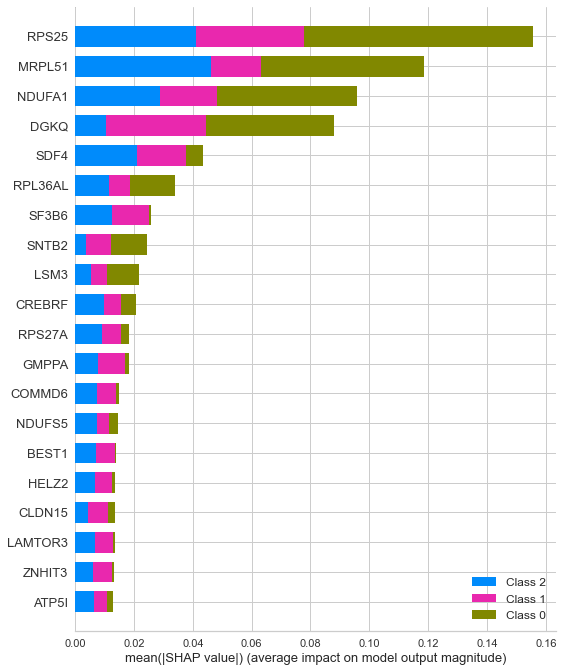

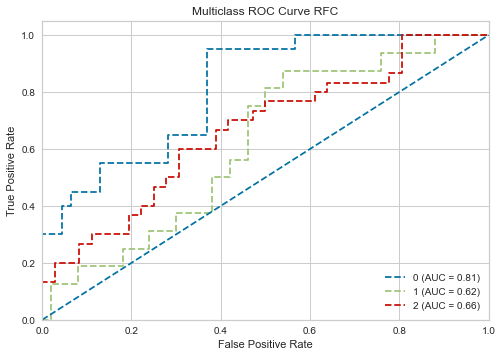

In [118]:
# training with tuned  parameters

# training and validation of randomforest model
rf=RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,n_estimators=150, random_state=500)
rf.fit(X_train_pr,Y_train_pr)
print(rf.score(X_train_pr,Y_train_pr))
print('Randomforestclassifer','\n',classification_report(Y_test,rf.predict(X_test_pr)))
print(confusion_matrix(Y_test,rf.predict(X_test_pr)))
print(roc_auc_score(Y_test,rf.predict_proba(X_test_pr),multi_class='ovr',average='weighted'))
print('train_error:-',log_loss(Y_train_pr,rf.predict_proba(X_train_pr)))
print('test_error:-',log_loss(Y_test,rf.predict_proba(X_test_pr)))
print("cohen's kappa:-",cohen_kappa_score(Y_test,rf.predict(X_test_pr)))
pred_prob = rf.predict_proba(X_test_pr)
print('Balance_accuracy_score:-',balanced_accuracy_score(Y_test,rf.predict(X_test_pr)))

import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_pr)
shap.summary_plot(shap_values,X_test_pr)


from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize y values
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# ROC curve for classes
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_class = y_test_binarized.shape[1]
classes = np.unique(Y_test)


for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotting
    plt.plot(fpr[i], tpr[i], linestyle='--', label='%s (AUC = %0.2f)'%(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC Curve RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

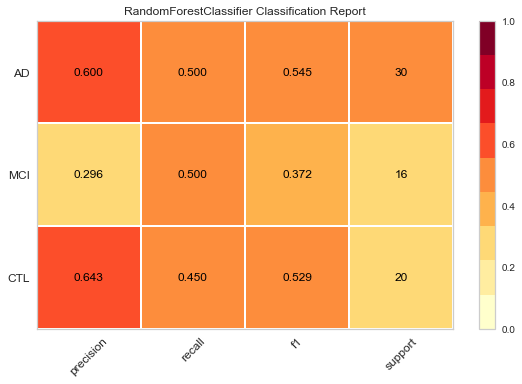

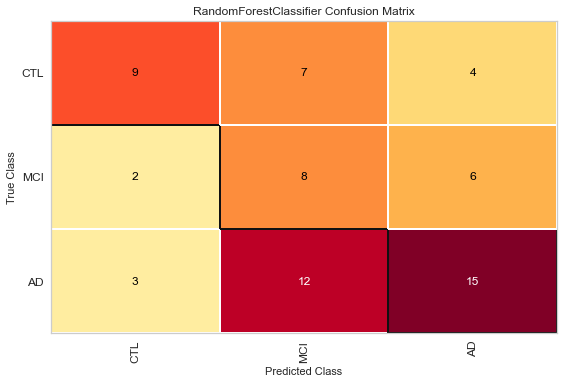

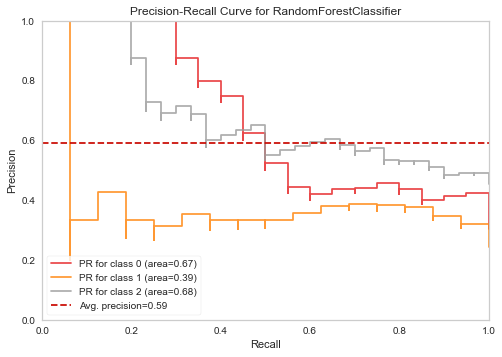

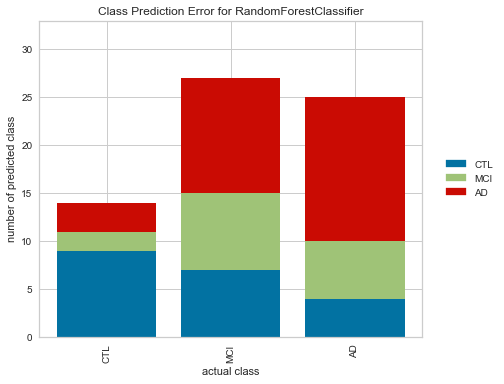

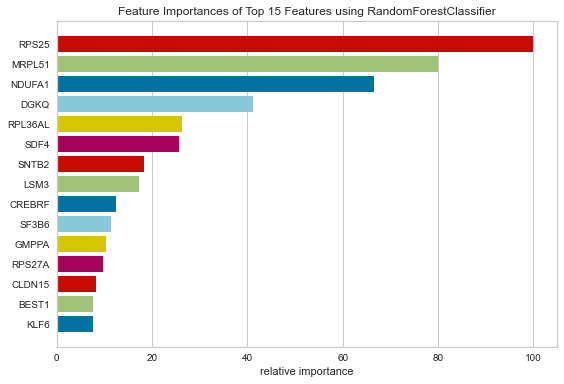

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using RandomForestClassifier'}, xlabel='relative importance'>,
                   estimator=RandomForestClassifier(max_depth=6,
                                                    max_features=None,
                                                    max_leaf_nodes=9,
                                                    n_estimators=150,
                                                    random_state=500),
                   topn=15)

In [98]:
# plotting through yellow brick classifier

# Specify the target classes
classes = ['CTL','MCI','AD']

model = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,n_estimators=150, random_state=500)
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train_pr, Y_train_pr)        # Fit the visualizer and the model
visualizer.score(X_test_pr, Y_test)        # Evaluate the model on the test data
visualizer.show(cmap='green')

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_pr, Y_train_pr)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_pr, Y_test)

# How did we do?
cm.show()


#roc_auc(model, X_train_pr, Y_train_pr, X_test_pr, Y_test, classes=classes)


# Create the visualizer, fit, score, and show it
#viz = precision_recall_curve(model, X_train_pr, Y_train_pr, X_test_pr, Y_test)

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(
    model,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_pr, Y_train_pr)
viz.score(X_test_pr, Y_test)
viz.show()

class_prediction_error(
    model,
    X_train_pr, Y_train_pr, X_test_pr, Y_test,
    classes=classes
)


# Use the quick method and immediately show the figure
feature_importances(model, X_train_pr, Y_train_pr,topn=15)


In [14]:
#cross validation for SVM

param_grid_svm={
    'kernel' : ['poly', 'rbf', 'sigmoid','linear'],
    'C' : [50, 10, 1.0, 0.1,0.2, 0.01],
    'gamma' : ['scale']}

grid_search_svm = GridSearchCV(SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True),param_grid=param_grid_svm,cv=5)

grid_search_svm.fit(X_train_pr,Y_train_pr)
print(grid_search_svm.score(X_train_pr,Y_train_pr))
print(grid_search_svm.best_estimator_)
print(classification_report(Y_test,grid_search_svm.predict(X_test_pr)))
print(roc_auc_score(Y_test,grid_search_svm.predict_proba(X_test_pr),multi_class='ovr',average='weighted'))
grid_search_svm.get_params

0.9971014492753624
SVC(break_ties=True, kernel='linear', probability=True, random_state=45)
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        20
           1       0.35      0.38      0.36        16
           2       0.51      0.60      0.55        30

    accuracy                           0.52        66
   macro avg       0.53      0.49      0.50        66
weighted avg       0.54      0.52      0.52        66

0.6843910115649248


<bound method BaseEstimator.get_params of GridSearchCV(cv=5,
             estimator=SVC(break_ties=True, probability=True, random_state=45),
             param_grid={'C': [50, 10, 1.0, 0.1, 0.2, 0.01], 'gamma': ['scale'],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']})>

Support vector classifier
1.0
SVC 
               precision    recall  f1-score   support

           0       0.77      0.50      0.61        20
           1       0.37      0.44      0.40        16
           2       0.53      0.60      0.56        30

    accuracy                           0.53        66
   macro avg       0.56      0.51      0.52        66
weighted avg       0.56      0.53      0.54        66

[[10  3  7]
 [ 0  7  9]
 [ 3  9 18]]
0.5363062442607897
0.6820377689942907
Balance_accuracy_score:- 0.5125000000000001


  0%|          | 0/66 [00:00<?, ?it/s]

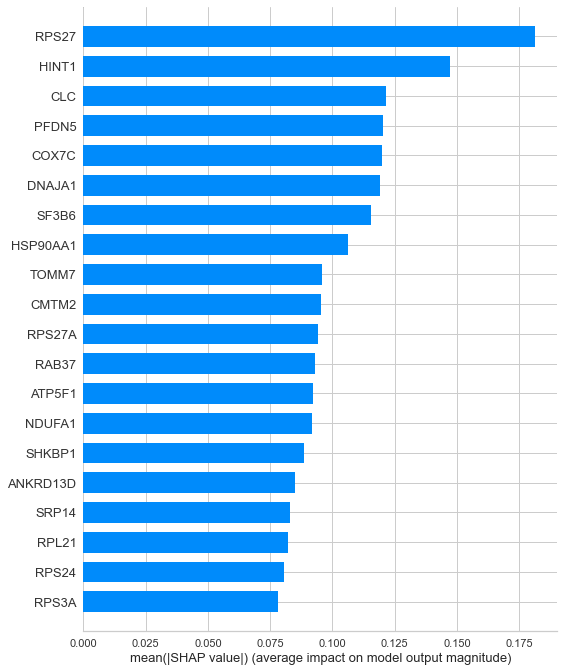

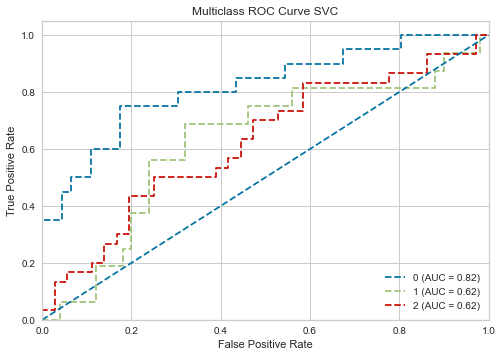

In [125]:
# training the svm model hypertuned parameters

print('Support vector classifier')
svc=SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True,kernel='poly',C= 50)
svc.fit(X_train_pr,Y_train_pr)
print(svc.score(X_train_pr,Y_train_pr))
print('SVC','\n',classification_report(Y_test,svc.predict(X_test_pr)))
print(confusion_matrix(Y_test,svc.predict(X_test_pr)))
print(f1_score(Y_test,svc.predict(X_test_pr),average="weighted"))
print(roc_auc_score(Y_test,svc.predict_proba(X_test_pr),multi_class='ovr',average='weighted'))
print('Balance_accuracy_score:-',balanced_accuracy_score(Y_test,svc.predict(X_test_pr)))

import shap
svm_explainer = shap.KernelExplainer(svc.predict,X_test_pr)
svm_shap_values = svm_explainer.shap_values(X_test_pr)
shap.summary_plot(svm_shap_values,X_test_pr,plot_type='bar')

pred_prob = svc.predict_proba(X_test_pr)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize y values
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# ROC curve for classes
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_class = y_test_binarized.shape[1]
classes = np.unique(Y_test)


for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotting
    plt.plot(fpr[i], tpr[i], linestyle='--', label='%s (AUC = %0.2f)'%(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC Curve SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

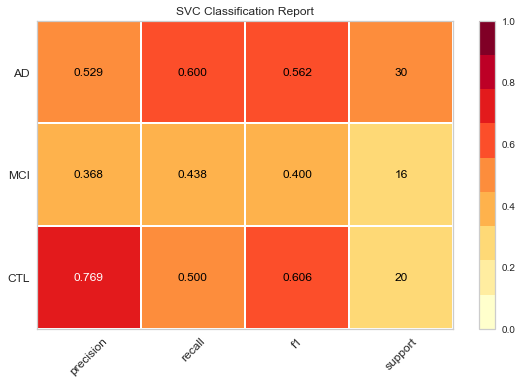

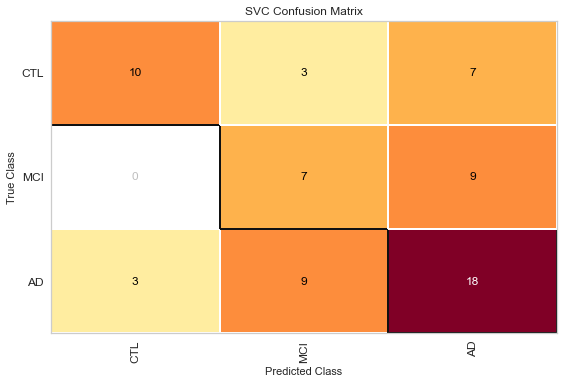

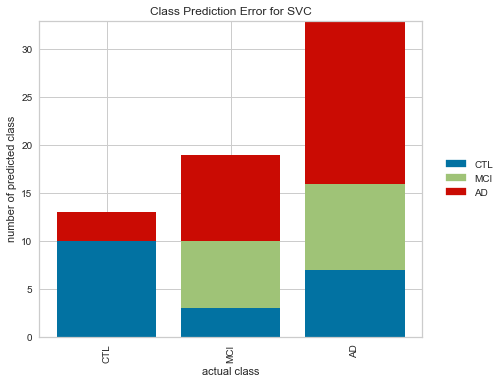

ClassPredictionError(ax=<AxesSubplot:title={'center':'Class Prediction Error for SVC'}, xlabel='actual class', ylabel='number of predicted class'>,
                     classes=['CTL', 'MCI', 'AD'],
                     estimator=SVC(C=50, break_ties=True, kernel='poly',
                                   probability=True, random_state=45))

In [89]:
# plotting through yellow brick classifier

# Specify the target classes
classes = ['CTL','MCI','AD']

model = SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True,C=50,kernel='poly')
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train_pr, Y_train_pr)        # Fit the visualizer and the model
visualizer.score(X_test_pr, Y_test)        # Evaluate the model on the test data
visualizer.show(cmap='green')

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_pr, Y_train_pr)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_pr, Y_test)

# How did we do?
cm.show()







# class prediction error

class_prediction_error(
    model,
    X_train_pr, Y_train_pr, X_test_pr, Y_test,
    classes=classes
)

# training on chi-square selected features

In [13]:
# training on chisquare selected features

X_train_chi=df_resampled[chi_feature]
X_test_chi=X_test[chi_feature]
Y_train_chi=df_resampled['Status']



# training and validation of randomforest model
rf=RandomForestClassifier(n_estimators=200,random_state=45)
rf.fit(X_train_chi,Y_train_chi)
print(rf.score(X_train_chi,Y_train_chi))
print('Randomforestclassifer','\n',classification_report(Y_test,rf.predict(X_test_chi)))
print(confusion_matrix(Y_test,rf.predict(X_test_chi)))
print(roc_auc_score(Y_test,rf.predict_proba(X_test_chi),multi_class='ovr',average='weighted'))

print('\n')


# training and validation of SVM model
print('Support vector classifier')
svc=SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True)
svc.fit(X_train_chi,Y_train_chi)
print(svc.score(X_train_chi,Y_train_chi))
print('SVC','\n',classification_report(Y_test,svc.predict(X_test_chi)))
print(confusion_matrix(Y_test,svc.predict(X_test_chi)))
print(f1_score(Y_test,svc.predict(X_test_chi),average="weighted"))
print(roc_auc_score(Y_test,svc.predict_proba(X_test_chi),multi_class='ovr',average='weighted'))

1.0
Randomforestclassifer 
               precision    recall  f1-score   support

           0       0.61      0.55      0.58        20
           1       0.26      0.31      0.29        16
           2       0.62      0.60      0.61        30

    accuracy                           0.52        66
   macro avg       0.50      0.49      0.49        66
weighted avg       0.53      0.52      0.52        66

[[11  6  3]
 [ 3  5  8]
 [ 4  8 18]]
0.7166260430390865


Support vector classifier
0.5449275362318841
SVC 
               precision    recall  f1-score   support

           0       0.67      0.30      0.41        20
           1       0.29      0.88      0.44        16
           2       0.56      0.17      0.26        30

    accuracy                           0.38        66
   macro avg       0.50      0.45      0.37        66
weighted avg       0.53      0.38      0.35        66

[[ 6 11  3]
 [ 1 14  1]
 [ 2 23  5]]
0.3480025721405032
0.6918423364075538


In [156]:
# cross validation on chisquared selected features

param_grid_rf = {
    'n_estimators':[25,50,100,150],
    'max_features':['sqrt','log2',None],
    'max_depth':[3,6,9],
    'max_leaf_nodes':[3,6,9],
}


grid_search = GridSearchCV(RandomForestClassifier(random_state=500),
                          param_grid=param_grid_rf,cv=5)

grid_search.fit(X_train_chi,Y_train_chi)
print(grid_search.score(X_train_chi,Y_train_chi))
print(grid_search.best_estimator_)
print(classification_report(Y_test,grid_search.predict(X_test_chi)))
print(roc_auc_score(Y_test,grid_search.predict_proba(X_test_chi),multi_class='ovr',average='weighted'))

0.8608695652173913
RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=25, random_state=500)
              precision    recall  f1-score   support

           0       0.61      0.55      0.58        20
           1       0.27      0.44      0.33        16
           2       0.59      0.43      0.50        30

    accuracy                           0.47        66
   macro avg       0.49      0.47      0.47        66
weighted avg       0.52      0.47      0.48        66

0.7099385155906895


0.8782608695652174
Randomforestclassifer 
               precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.26      0.44      0.33        16
           2       0.62      0.50      0.56        30

    accuracy                           0.48        66
   macro avg       0.52      0.48      0.48        66
weighted avg       0.55      0.48      0.50        66

[[10  7  3]
 [ 3  7  6]
 [ 2 13 15]]
0.7225925925925926
train_error:- 0.491803482794902
test_error:- 0.9570479806365433
cohen's kappa:- 0.2272727272727273
Balance_accuracy_score:- 0.4791666666666667


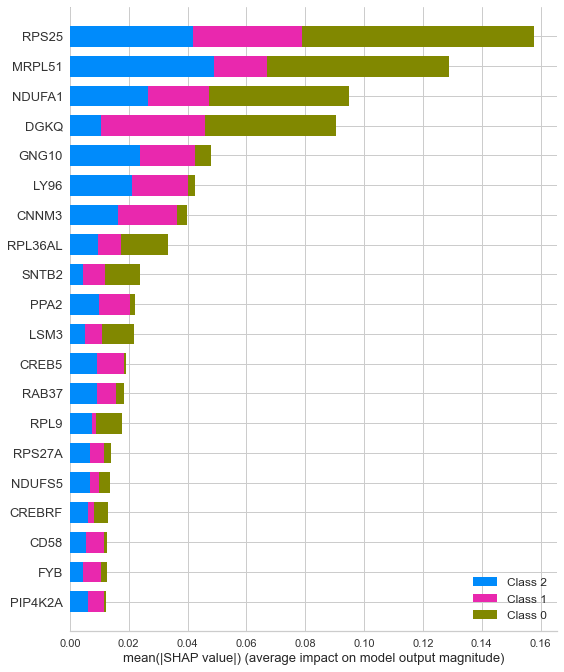

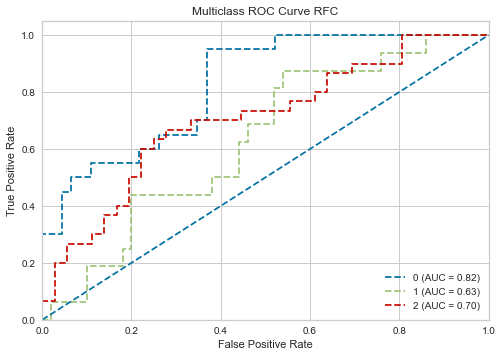

In [122]:
# training on tuned parameters

# training and validation of randomforest model
rf=RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,n_estimators=150, random_state=500)
rf.fit(X_train_chi,Y_train_chi)
print(rf.score(X_train_chi,Y_train_chi))
print('Randomforestclassifer','\n',classification_report(Y_test,rf.predict(X_test_chi)))
print(confusion_matrix(Y_test,rf.predict(X_test_chi)))
print(roc_auc_score(Y_test,rf.predict_proba(X_test_chi),multi_class='ovr',average='weighted'))
print('train_error:-',log_loss(Y_train_chi,rf.predict_proba(X_train_chi)))
print('test_error:-',log_loss(Y_test,rf.predict_proba(X_test_chi)))
print("cohen's kappa:-",cohen_kappa_score(Y_test,rf.predict(X_test_chi)))
print('Balance_accuracy_score:-',balanced_accuracy_score(Y_test,rf.predict(X_test_chi)))
pred_prob = rf.predict_proba(X_test_chi)

import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_chi)
shap.summary_plot(shap_values,X_test_chi)


from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize y values
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# ROC curve for classes
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_class = y_test_binarized.shape[1]
classes = np.unique(Y_test)


for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotting
    plt.plot(fpr[i], tpr[i], linestyle='--', label='%s (AUC = %0.2f)'%(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC Curve RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

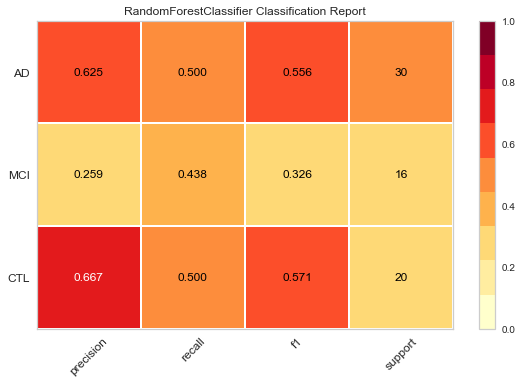

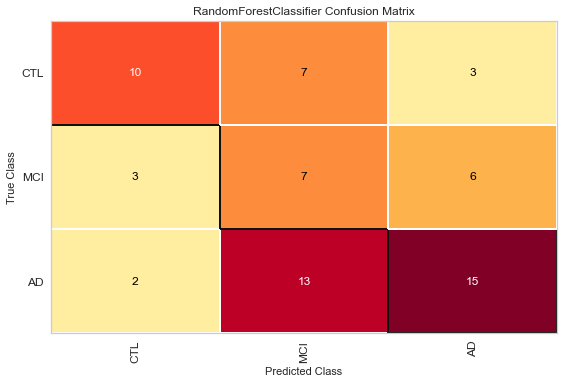

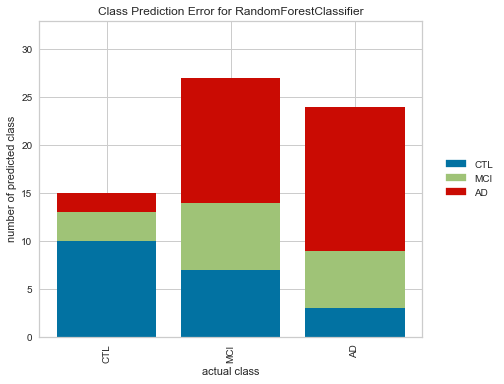

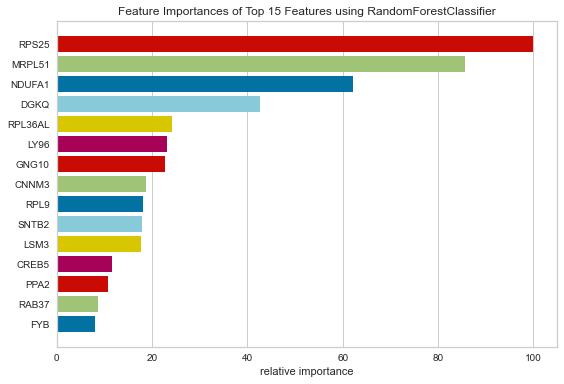

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using RandomForestClassifier'}, xlabel='relative importance'>,
                   estimator=RandomForestClassifier(max_depth=6,
                                                    max_features=None,
                                                    max_leaf_nodes=9,
                                                    n_estimators=150,
                                                    random_state=500),
                   topn=15)

In [90]:
# plotting through yellow brick classifier

# Specify the target classes
classes = ['CTL','MCI','AD']

model = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,n_estimators=150, random_state=500)
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train_chi, Y_train_chi)        # Fit the visualizer and the model
visualizer.score(X_test_chi, Y_test)        # Evaluate the model on the test data
visualizer.show(cmap='green')

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_chi, Y_train_chi)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_chi, Y_test)

# How did we do?
cm.show()





# class prediction error

class_prediction_error(
   model,
    X_train_chi, Y_train_chi, X_test_chi, Y_test,
    classes=classes
)


# Use the quick method and immediately show the figure
feature_importances(model, X_train_chi, Y_train_chi,topn=15)

In [16]:
#cross validation for SVM

param_grid_svm={
    'kernel' : ['poly', 'rbf', 'sigmoid','linear'],
    'C' : [50, 10, 1.0, 0.1,0.2, 0.01],
    'gamma' : ['scale']}

grid_search_svm = GridSearchCV(SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True),param_grid=param_grid_svm,cv=5)

grid_search_svm.fit(X_train_chi,Y_train_chi)
print(grid_search_svm.score(X_train_chi,Y_train_chi))
print(grid_search_svm.best_estimator_)
print(classification_report(Y_test,grid_search_svm.predict(X_test_chi)))
print(roc_auc_score(Y_test,grid_search_svm.predict_proba(X_test_chi),multi_class='ovr',average='weighted'))
grid_search_svm.get_params

1.0
SVC(C=50, break_ties=True, kernel='poly', probability=True, random_state=45)
              precision    recall  f1-score   support

           0       0.79      0.55      0.65        20
           1       0.26      0.38      0.31        16
           2       0.59      0.57      0.58        30

    accuracy                           0.52        66
   macro avg       0.54      0.50      0.51        66
weighted avg       0.57      0.52      0.53        66

0.7210283999414434


<bound method BaseEstimator.get_params of GridSearchCV(cv=5,
             estimator=SVC(break_ties=True, probability=True, random_state=45),
             param_grid={'C': [50, 10, 1.0, 0.1, 0.2, 0.01], 'gamma': ['scale'],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']})>

Support vector classifier
1.0
SVC 
               precision    recall  f1-score   support

           0       0.79      0.55      0.65        20
           1       0.26      0.38      0.31        16
           2       0.59      0.57      0.58        30

    accuracy                           0.52        66
   macro avg       0.54      0.50      0.51        66
weighted avg       0.57      0.52      0.53        66

[[11  6  3]
 [ 1  6  9]
 [ 2 11 17]]
0.53261195434675
0.7210283999414434
Balance_accuracy_score:- 0.49722222222222223


  0%|          | 0/66 [00:00<?, ?it/s]

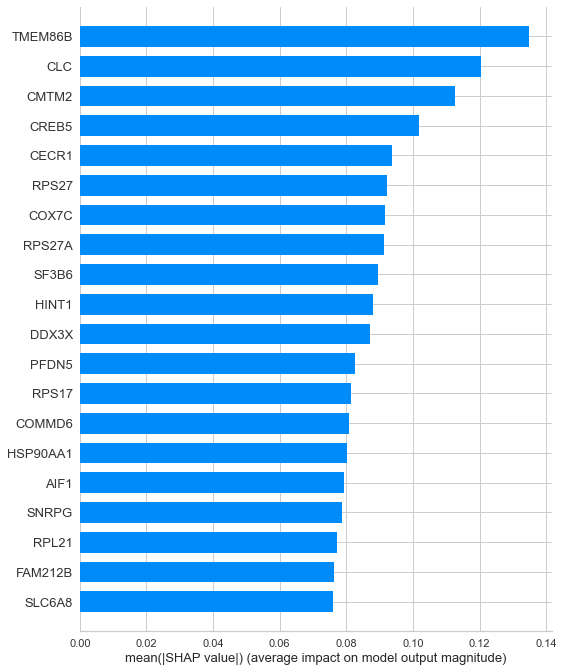

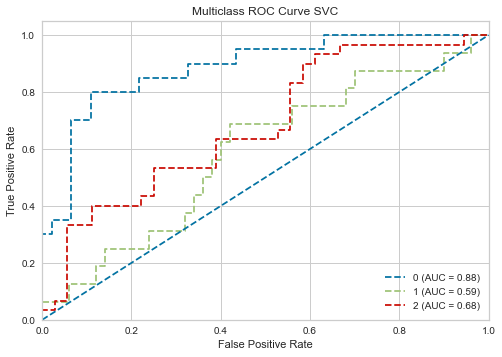

In [34]:
# training the svm model hypertuned parameters

print('Support vector classifier')
svc=SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True,kernel='poly',C= 50)
svc.fit(X_train_chi,Y_train_chi)
print(svc.score(X_train_chi,Y_train_chi))
print('SVC','\n',classification_report(Y_test,svc.predict(X_test_chi)))
print(confusion_matrix(Y_test,svc.predict(X_test_chi)))
print(f1_score(Y_test,svc.predict(X_test_chi),average="weighted"))
print(roc_auc_score(Y_test,svc.predict_proba(X_test_chi),multi_class='ovr',average='weighted'))
print('Balance_accuracy_score:-',balanced_accuracy_score(Y_test,svc.predict(X_test_chi)))

import shap
svm_explainer = shap.KernelExplainer(svc.predict,X_test_chi)
svm_shap_values = svm_explainer.shap_values(X_test_chi)
shap.summary_plot(svm_shap_values,X_test_chi,plot_type='bar')

pred_prob = svc.predict_proba(X_test_chi)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize y values
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# ROC curve for classes
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_class = y_test_binarized.shape[1]
classes = np.unique(Y_test)


for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotting
    plt.plot(fpr[i], tpr[i], linestyle='--', label='%s (AUC = %0.2f)'%(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC Curve SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

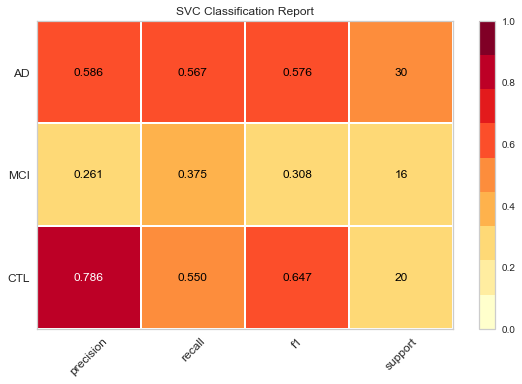

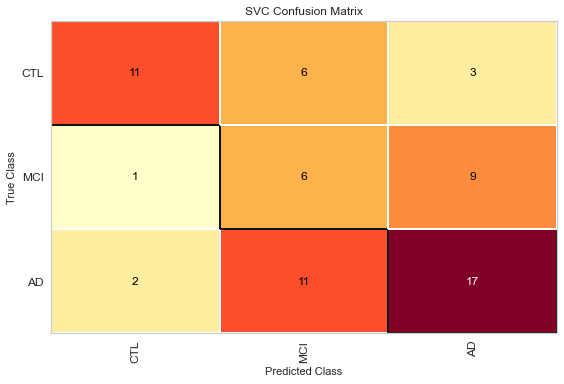

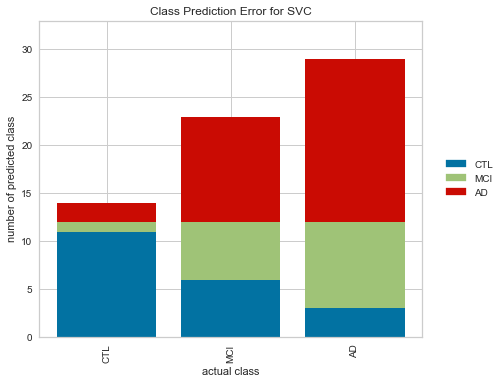

ClassPredictionError(ax=<AxesSubplot:title={'center':'Class Prediction Error for SVC'}, xlabel='actual class', ylabel='number of predicted class'>,
                     classes=['CTL', 'MCI', 'AD'],
                     estimator=SVC(C=50, break_ties=True, kernel='poly',
                                   probability=True, random_state=45))

In [14]:
# plotting through yellow brick classifier

# Specify the target classes
classes = ['CTL','MCI','AD']

model = SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True,C=50,kernel='poly')
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train_chi, Y_train_chi)        # Fit the visualizer and the model
visualizer.score(X_test_chi, Y_test)        # Evaluate the model on the test data
visualizer.show(cmap='green')

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_chi, Y_train_chi)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_chi, Y_test)

# How did we do?
cm.show()







# class prediction error

class_prediction_error(
    model,
    X_train_chi, Y_train_chi, X_test_chi, Y_test,
    classes=classes
)

# training RFE_selected features

# RFe_randomforest

In [19]:
# training on RFE_rf selected features

X_train_rerf=df_resampled[rfe_feature]
X_test_rerf=X_test[rfe_feature]
Y_train_rerf=df_resampled['Status']

# training and validation of randomforest model
rf=RandomForestClassifier(n_estimators=200,random_state=45)
rf.fit(X_train_rerf,Y_train_rerf)
print(rf.score(X_train_rerf,Y_train_rerf))
print('Randomforestclassifer','\n',classification_report(Y_test,rf.predict(X_test_rerf)))
print(confusion_matrix(Y_test,rf.predict(X_test_rerf)))
print(roc_auc_score(Y_test,rf.predict_proba(X_test_rerf),multi_class='ovr',average='weighted'))

1.0
Randomforestclassifer 
               precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.35      0.44      0.39        16
           2       0.58      0.60      0.59        30

    accuracy                           0.53        66
   macro avg       0.53      0.51      0.52        66
weighted avg       0.55      0.53      0.54        66

[[10  4  6]
 [ 2  7  7]
 [ 3  9 18]]
0.7276529790660227


In [159]:
# cross validation on rfe_rf selected features

param_grid_rf = {
    'n_estimators':[25,50,100,150],
    'max_features':['sqrt','log2',None],
    'max_depth':[3,6,9],
    'max_leaf_nodes':[3,6,9],
}


grid_search = GridSearchCV(RandomForestClassifier(random_state=500),
                          param_grid=param_grid_rf,cv=5)

grid_search.fit(X_train_rerf,Y_train_rerf)
print(grid_search.score(X_train_rerf,Y_train_rerf))
print(grid_search.best_estimator_)
print(classification_report(Y_test,grid_search.predict(X_test_rerf)))
print(roc_auc_score(Y_test,grid_search.predict_proba(X_test_rerf),multi_class='ovr',average='weighted'))

0.8985507246376812
RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=150, random_state=500)
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.37      0.62      0.47        16
           2       0.62      0.50      0.56        30

    accuracy                           0.53        66
   macro avg       0.55      0.54      0.53        66
weighted avg       0.58      0.53      0.54        66

0.7267303469477383


0.8869565217391304
Randomforestclassifer 
               precision    recall  f1-score   support

           0       0.62      0.50      0.56        20
           1       0.31      0.50      0.38        16
           2       0.67      0.53      0.59        30

    accuracy                           0.52        66
   macro avg       0.53      0.51      0.51        66
weighted avg       0.57      0.52      0.53        66

[[10  6  4]
 [ 4  8  4]
 [ 2 12 16]]
0.7366608110086371
train_error:- 0.4691437701570851
test_error:- 0.9455226204409866
cohen's kappa:- 0.27172413793103445
Balance_accuracy_score:- 0.5111111111111111


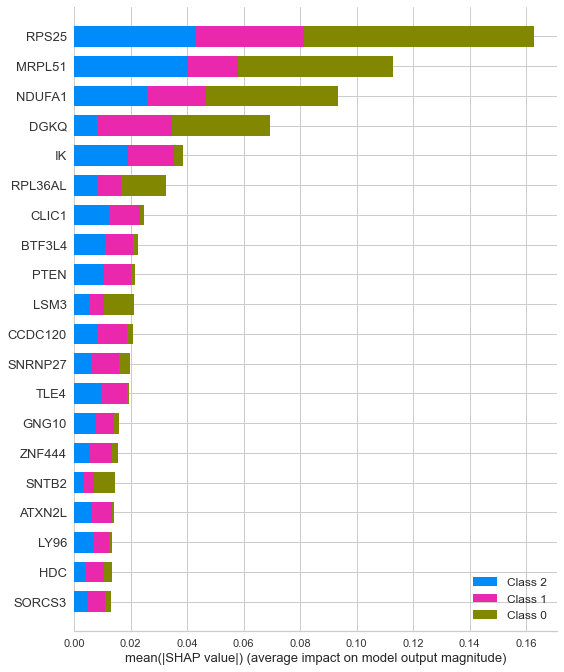

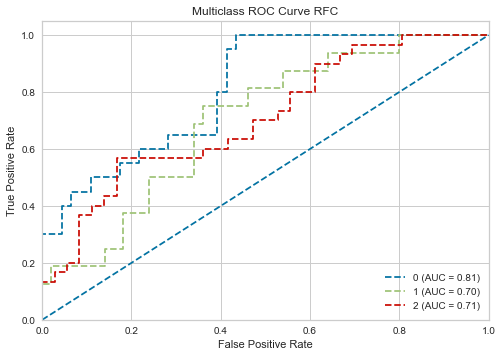

In [123]:
# rfe_rf with tuned parameters

# training and validation of randomforest model
rf=RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,n_estimators=150, random_state=500)
rf.fit(X_train_rerf,Y_train_rerf)
print(rf.score(X_train_rerf,Y_train_rerf))
print('Randomforestclassifer','\n',classification_report(Y_test,rf.predict(X_test_rerf)))
print(confusion_matrix(Y_test,rf.predict(X_test_rerf)))
print(roc_auc_score(Y_test,rf.predict_proba(X_test_rerf),multi_class='ovr',average='weighted'))
print('train_error:-',log_loss(Y_train_rerf,rf.predict_proba(X_train_rerf)))
print('test_error:-',log_loss(Y_test,rf.predict_proba(X_test_rerf)))
print("cohen's kappa:-",cohen_kappa_score(Y_test,rf.predict(X_test_rerf)))
print('Balance_accuracy_score:-',balanced_accuracy_score(Y_test,rf.predict(X_test_rerf)))
pred_prob = rf.predict_proba(X_test_rerf)

import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_rerf)
shap.summary_plot(shap_values,X_test_rerf)


from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize y values
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# ROC curve for classes
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_class = y_test_binarized.shape[1]
classes = np.unique(Y_test)


for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotting
    plt.plot(fpr[i], tpr[i], linestyle='--', label='%s (AUC = %0.2f)'%(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC Curve RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

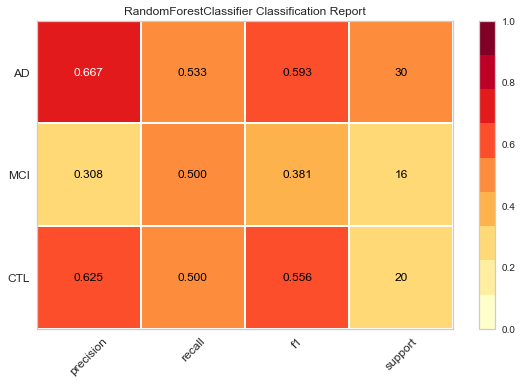

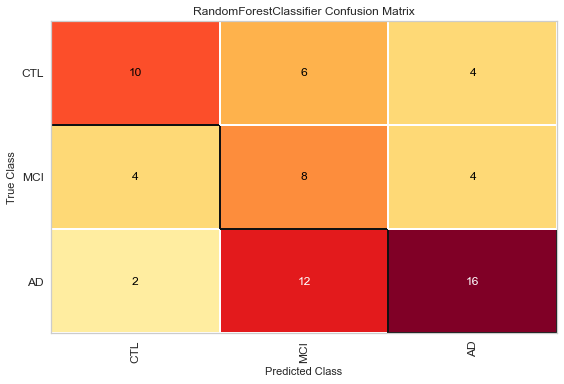

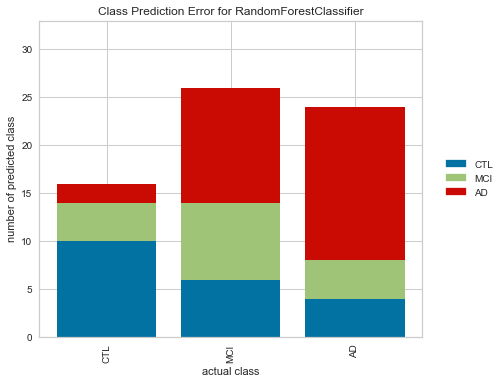

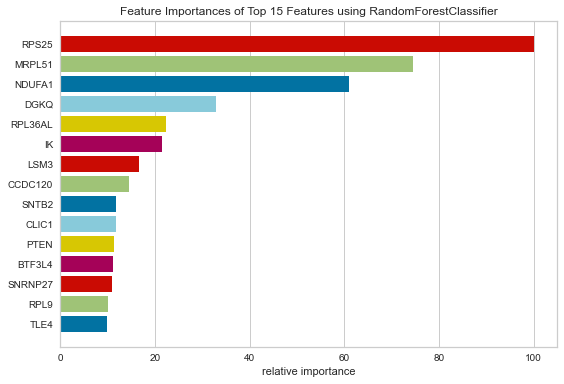

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using RandomForestClassifier'}, xlabel='relative importance'>,
                   estimator=RandomForestClassifier(max_depth=6,
                                                    max_features=None,
                                                    max_leaf_nodes=9,
                                                    n_estimators=150,
                                                    random_state=500),
                   topn=15)

In [93]:
# plotting through yellow brick classifier

# Specify the target classes
classes = ['CTL','MCI','AD']

model = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,n_estimators=150, random_state=500)
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train_rerf, Y_train_rerf)        # Fit the visualizer and the model
visualizer.score(X_test_rerf, Y_test)        # Evaluate the model on the test data
visualizer.show(cmap='green')

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_rerf, Y_train_rerf)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_rerf, Y_test)

# How did we do?
cm.show()


# class prediction error

class_prediction_error(
   model,
    X_train_rerf, Y_train_rerf, X_test_rerf, Y_test,
    classes=classes,
)


# Use the quick method and immediately show the figure
feature_importances(model, X_train_rerf, Y_train_resampled,topn=15)

# RFE_svc

In [18]:
# training on RFE_rf selected features

X_train_resvc=df_resampled[rfe_feature_svc]
X_test_resvc=X_test[rfe_feature_svc]
Y_train_resvc=df_resampled['Status']



# training and validation of SVM model
print('Support vector classifier')
svc=SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True)
svc.fit(X_train_resvc,Y_train_resvc)
print(svc.score(X_train_resvc,Y_train_resvc))
print('SVC','\n',classification_report(Y_test,svc.predict(X_test_resvc)))
print(confusion_matrix(Y_test,svc.predict(X_test_resvc)))
print(f1_score(Y_test,svc.predict(X_test_resvc),average="weighted"))
print(roc_auc_score(Y_test,svc.predict_proba(X_test_resvc),multi_class='ovr',average='weighted'))
print('train_error:-',log_loss(Y_train_resvc,svc.predict_proba(X_train_resvc)))
print('test_error:-',log_loss(Y_test,svc.predict_proba(X_test_resvc)))

Support vector classifier
0.5971014492753624
SVC 
               precision    recall  f1-score   support

           0       0.75      0.30      0.43        20
           1       0.34      0.88      0.49        16
           2       0.59      0.33      0.43        30

    accuracy                           0.45        66
   macro avg       0.56      0.50      0.45        66
weighted avg       0.58      0.45      0.44        66

[[ 6  8  6]
 [ 1 14  1]
 [ 1 19 10]]
0.44237932031884997
0.7160818328209633
train_error:- 0.7665808187760901
test_error:- 0.9681927429236764


In [25]:
d= list(rfe_feature_svc)
pd.DataFrame(d).to_csv('gene_validation.csv')

In [20]:
#cross validation for SVM

param_grid_svm={
    'kernel' : ['poly', 'rbf', 'sigmoid','linear'],
    'C' : [50, 10, 1.0, 0.1,0.2,0.05, 0.01],
    'gamma' : ['scale']}

grid_search_svm = GridSearchCV(SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True),param_grid=param_grid_svm,cv=8)

grid_search_svm.fit(X_train_resvc,Y_train_resvc)
print(grid_search_svm.score(X_train_resvc,Y_train_resvc))
print(grid_search_svm.best_estimator_)
print(classification_report(Y_test,grid_search_svm.predict(X_test_resvc)))
print(roc_auc_score(Y_test,grid_search_svm.predict_proba(X_test_resvc),multi_class='ovr',average='weighted'))
grid_search_svm.get_params

1.0
SVC(C=50, break_ties=True, kernel='poly', probability=True, random_state=45)
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.52      0.69      0.59        16
           2       0.73      0.63      0.68        30

    accuracy                           0.71        66
   macro avg       0.72      0.72      0.71        66
weighted avg       0.73      0.71      0.72        66

0.8819257795344753


<bound method BaseEstimator.get_params of GridSearchCV(cv=8,
             estimator=SVC(break_ties=True, probability=True, random_state=45),
             param_grid={'C': [50, 10, 1.0, 0.1, 0.2, 0.05, 0.01],
                         'gamma': ['scale'],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']})>

Support vector classifier
1.0
SVC 
               precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.52      0.69      0.59        16
           2       0.73      0.63      0.68        30

    accuracy                           0.71        66
   macro avg       0.72      0.72      0.71        66
weighted avg       0.73      0.71      0.72        66

[[17  1  2]
 [ 0 11  5]
 [ 2  9 19]]
0.7167659667659668
0.8819257795344753
train_error:- 0.08991219034471862
test_error:- 0.6025500532311792
Balancedaccuracyscore:- 0.7236111111111111


  0%|          | 0/66 [00:00<?, ?it/s]

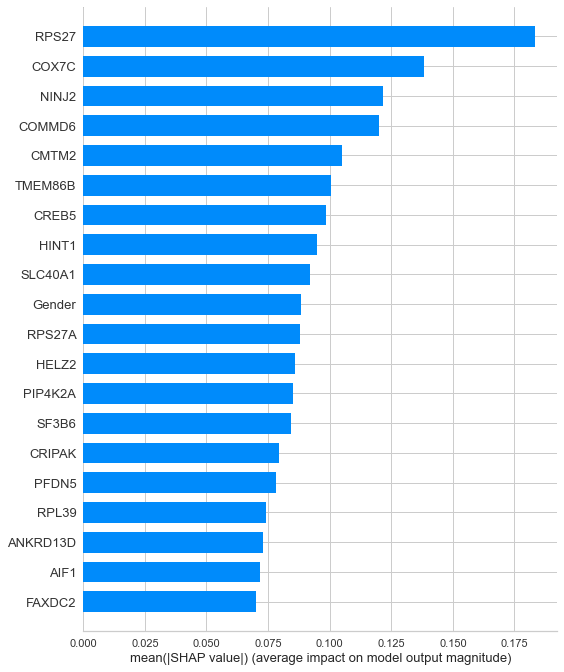

In [121]:
# svc using tuned parameters

# training and validation of SVM model
print('Support vector classifier')
svc=SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True,C=50,kernel='poly')
svc.fit(X_train_resvc,Y_train_resvc)
print(svc.score(X_train_resvc,Y_train_resvc))
print('SVC','\n',classification_report(Y_test,svc.predict(X_test_resvc)))
print(confusion_matrix(Y_test,svc.predict(X_test_resvc)))
print(f1_score(Y_test,svc.predict(X_test_resvc),average="weighted"))
print(roc_auc_score(Y_test,svc.predict_proba(X_test_resvc),multi_class='ovr',average='weighted'))
print('train_error:-',log_loss(Y_train_resvc,svc.predict_proba(X_train_resvc)))
print('test_error:-',log_loss(Y_test,svc.predict_proba(X_test_resvc)))
print('Balancedaccuracyscore:-',balanced_accuracy_score(Y_test,svc.predict(X_test_resvc)))
import shap
svm_explainer = shap.KernelExplainer(svc.predict,X_test_resvc)
svm_shap_values = svm_explainer.shap_values(X_test_resvc)
shap.summary_plot(svm_shap_values,X_test_resvc,plot_type='bar')





In [26]:
import shap
svm_explainer = shap.KernelExplainer(svc.predict,X_test_resvc)
svm_shap_values = svm_explainer.shap_values(X_test_resvc)
svm_shap_values

  0%|          | 0/66 [00:00<?, ?it/s]

array([[ 0.00134041,  0.00574823,  0.        , ..., -0.00696713,
         0.004847  , -0.013939  ],
       [ 0.04033637, -0.02033451,  0.00624391, ..., -0.01345484,
         0.0383496 ,  0.03358035],
       [ 0.        ,  0.00143644,  0.01106738, ...,  0.00220393,
         0.        , -0.01872572],
       ...,
       [-0.01122693,  0.00681921,  0.        , ..., -0.00440177,
         0.        ,  0.04097272],
       [-0.00104719,  0.00135457, -0.00343638, ...,  0.00086936,
         0.        ,  0.00334808],
       [ 0.00492046,  0.        ,  0.00289542, ...,  0.        ,
         0.        ,  0.01145614]])

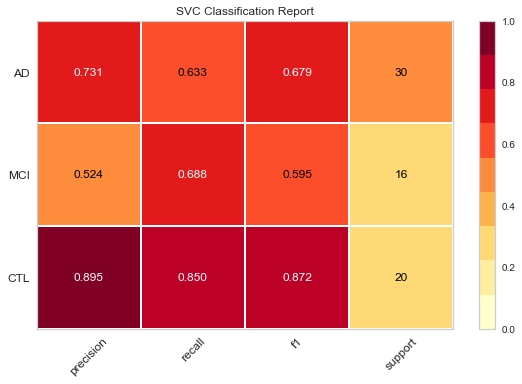

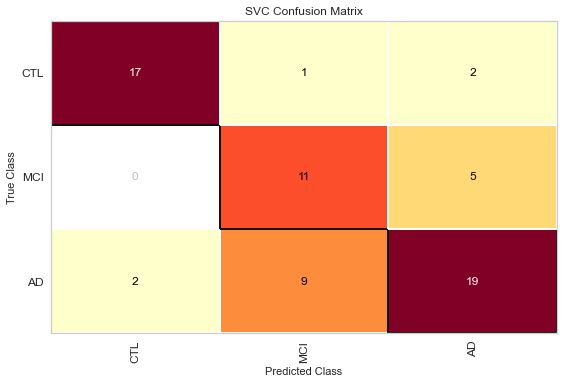

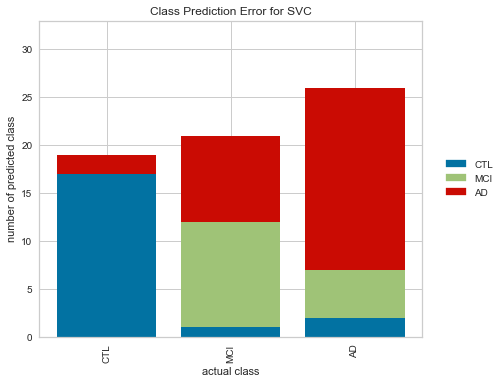

ClassPredictionError(ax=<AxesSubplot:title={'center':'Class Prediction Error for SVC'}, xlabel='actual class', ylabel='number of predicted class'>,
                     classes=['CTL', 'MCI', 'AD'],
                     estimator=SVC(C=50, break_ties=True, kernel='poly',
                                   probability=True, random_state=45))

In [88]:
# plotting through yellow brick classifier

# Specify the target classes
classes = ['CTL','MCI','AD']

model = SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True,C=50,kernel='poly')
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train_resvc, Y_train_resvc)        # Fit the visualizer and the model
visualizer.score(X_test_resvc, Y_test)        # Evaluate the model on the test data
visualizer.show(cmap='green')

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_resvc, Y_train_resvc)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_resvc, Y_test)

# How did we do?
cm.show()

# class prediction error

class_prediction_error(
    model,
    X_train_resvc, Y_train_resvc, X_test_resvc, Y_test,
    classes=classes
)




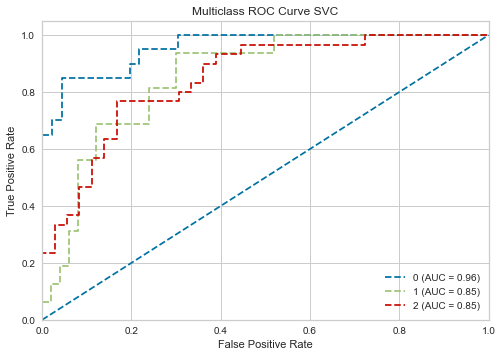

In [99]:
pred_prob = svc.predict_proba(X_test_resvc)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize y values
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# ROC curve for classes
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_class = y_test_binarized.shape[1]
classes = np.unique(Y_test)


for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotting
    plt.plot(fpr[i], tpr[i], linestyle='--', label='%s (AUC = %0.2f)'%(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC Curve SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()



# training on emdedded feature selection data

# embedded_rf

In [12]:
# training on embedded rf selected features

X_train_ebrf=df_resampled[embeded_rf_feature]
X_test_ebrf=X_test[embeded_rf_feature]
Y_train_ebrf=df_resampled['Status']



# training and validation of randomforest model
rf=RandomForestClassifier(n_estimators=200,random_state=45)
rf.fit(X_train_ebrf,Y_train_ebrf)
print(rf.score(X_train_ebrf,Y_train_ebrf))
print('Randomforestclassifer','\n',classification_report(Y_test,rf.predict(X_test_ebrf)))
print(confusion_matrix(Y_test,rf.predict(X_test_ebrf)))
print(roc_auc_score(Y_test,rf.predict_proba(X_test_ebrf),multi_class='ovr',average='weighted'))

1.0
Randomforestclassifer 
               precision    recall  f1-score   support

           0       0.59      0.50      0.54        20
           1       0.33      0.44      0.38        16
           2       0.61      0.57      0.59        30

    accuracy                           0.52        66
   macro avg       0.51      0.50      0.50        66
weighted avg       0.54      0.52      0.52        66

[[10  5  5]
 [ 3  7  6]
 [ 4  9 17]]
0.73687527448397


In [163]:
# cross validation on embedded_rf selected features

param_grid_rf = {
    'n_estimators':[25,50,100,150],
    'max_features':['sqrt','log2',None],
    'max_depth':[3,6,9],
    'max_leaf_nodes':[3,6,9],
}


grid_search = GridSearchCV(RandomForestClassifier(random_state=500),
                          param_grid=param_grid_rf,cv=5)

grid_search.fit(X_train_ebrf,Y_train_ebrf)
print(grid_search.score(X_train_ebrf,Y_train_ebrf))
print(grid_search.best_estimator_)
print(classification_report(Y_test,grid_search.predict(X_test_ebrf)))
print(roc_auc_score(Y_test,grid_search.predict_proba(X_test_ebrf),multi_class='ovr',average='weighted'))

0.8927536231884058
RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=150, random_state=500)
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        20
           1       0.31      0.50      0.38        16
           2       0.62      0.53      0.57        30

    accuracy                           0.52        66
   macro avg       0.55      0.51      0.51        66
weighted avg       0.57      0.52      0.53        66

0.7296567120480164


0.8753623188405797
Randomforestclassifer 
               precision    recall  f1-score   support

           0       0.62      0.50      0.56        20
           1       0.28      0.50      0.36        16
           2       0.57      0.40      0.47        30

    accuracy                           0.45        66
   macro avg       0.49      0.47      0.46        66
weighted avg       0.52      0.45      0.47        66

[[10  5  5]
 [ 4  8  4]
 [ 2 16 12]]
0.7311045234958279
train_error:- 0.4754698522019732
test_error:- 0.9445552283147819
cohen's kappa:- 0.19238613188307263
Balance_accuracy_score:- 0.4666666666666666


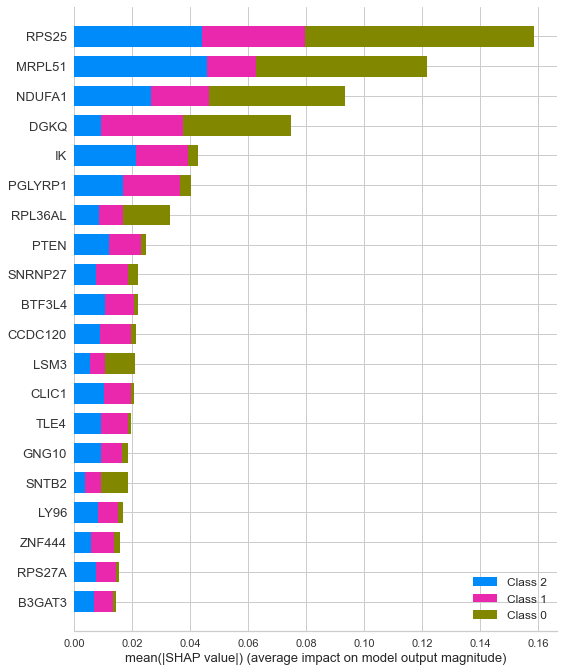

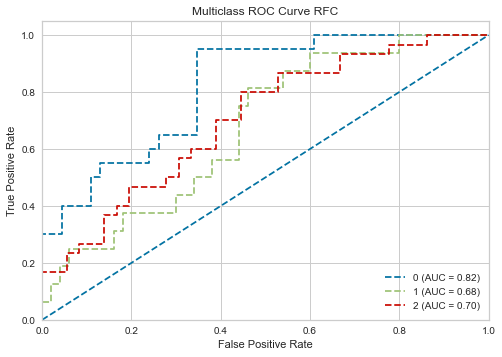

In [124]:
# Randomforest with selected parameters

# training and validation of randomforest model
rf=RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,n_estimators=150, random_state=500)
rf.fit(X_train_ebrf,Y_train_ebrf)
print(rf.score(X_train_ebrf,Y_train_ebrf))
print('Randomforestclassifer','\n',classification_report(Y_test,rf.predict(X_test_ebrf)))
print(confusion_matrix(Y_test,rf.predict(X_test_ebrf)))
print(roc_auc_score(Y_test,rf.predict_proba(X_test_ebrf),multi_class='ovr',average='weighted'))
print('train_error:-',log_loss(Y_train_ebrf,rf.predict_proba(X_train_ebrf)))
print('test_error:-',log_loss(Y_test,rf.predict_proba(X_test_ebrf)))
print("cohen's kappa:-",cohen_kappa_score(Y_test,rf.predict(X_test_ebrf)))
print('Balance_accuracy_score:-',balanced_accuracy_score(Y_test,rf.predict(X_test_ebrf)))
pred_prob = rf.predict_proba(X_test_ebrf)

import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_ebrf)
shap.summary_plot(shap_values,X_test_ebrf)

# Binarize y values
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# ROC curve for classes
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_class = y_test_binarized.shape[1]
classes = np.unique(Y_test)


for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotting
    plt.plot(fpr[i], tpr[i], linestyle='--', label='%s (AUC = %0.2f)'%(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC Curve RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

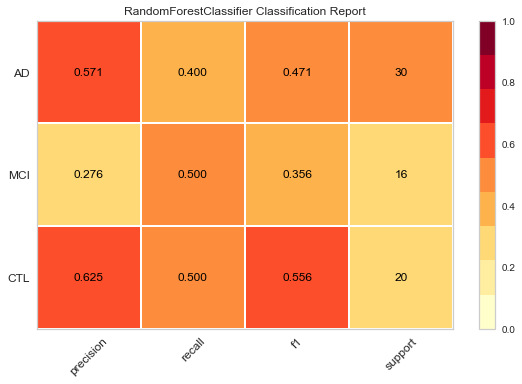

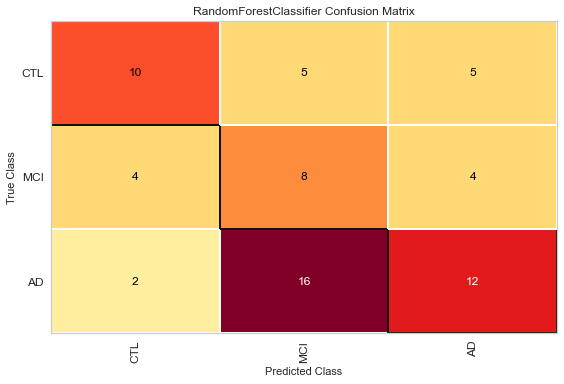

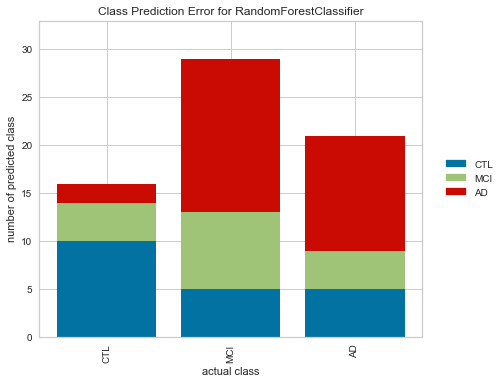

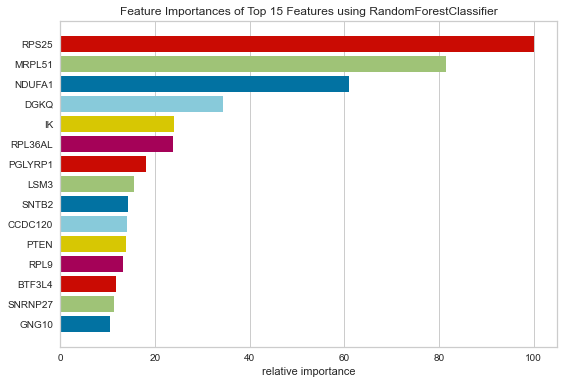

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using RandomForestClassifier'}, xlabel='relative importance'>,
                   estimator=RandomForestClassifier(max_depth=6,
                                                    max_features=None,
                                                    max_leaf_nodes=9,
                                                    n_estimators=150,
                                                    random_state=500),
                   topn=15)

In [94]:
# plotting through yellow brick classifier

# Specify the target classes
classes = ['CTL','MCI','AD']

model = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,n_estimators=150, random_state=500)
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train_ebrf, Y_train_ebrf)        # Fit the visualizer and the model
visualizer.score(X_test_ebrf, Y_test)        # Evaluate the model on the test data
visualizer.show(cmap='green')

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_ebrf, Y_train_ebrf)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_ebrf, Y_test)

# How did we do?
cm.show()


# class prediction error

class_prediction_error(
   model,
    X_train_ebrf, Y_train_ebrf, X_test_ebrf, Y_test,
    classes=classes
)


# Use the quick method and immediately show the figure
feature_importances(model, X_train_ebrf, Y_train_ebrf,topn=15)

# embedded SVC feature selection

In [13]:
# training on RFE_svc selected features

X_train_embsvc=df_resampled[embeded_svc_feature]
X_test_embsvc=X_test[embeded_svc_feature]
Y_train_embsvc=df_resampled['Status']



# training and validation of SVM model
print('Support vector classifier')
svc=SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True)
svc.fit(X_train_embsvc,Y_train_embsvc)
print(svc.score(X_train_embsvc,Y_train_embsvc))
print('SVC','\n',classification_report(Y_test,svc.predict(X_test_embsvc)))
print(confusion_matrix(Y_test,svc.predict(X_test_embsvc)))
print(f1_score(Y_test,svc.predict(X_test_embsvc),average="weighted"))
print(roc_auc_score(Y_test,svc.predict_proba(X_test_embsvc),multi_class='ovr',average='weighted'))

Support vector classifier
0.6115942028985507
SVC 
               precision    recall  f1-score   support

           0       0.75      0.30      0.43        20
           1       0.32      0.69      0.44        16
           2       0.50      0.40      0.44        30

    accuracy                           0.44        66
   macro avg       0.52      0.46      0.44        66
weighted avg       0.53      0.44      0.44        66

[[ 6  6  8]
 [ 1 11  4]
 [ 1 17 12]]
0.43855699855699853
0.6984394671351193


In [24]:
#cross validation for SVM

param_grid_svm={
    'kernel' : ['poly', 'rbf', 'sigmoid','linear'],
    'C' : [50, 10, 1.0, 0.1, 0.01],
    'gamma' : ['scale']}

grid_search_svm = GridSearchCV(SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True),param_grid=param_grid_svm,cv=5)

grid_search_svm.fit(X_train_embsvc,Y_train_embsvc)
print(grid_search_svm.score(X_train_embsvc,Y_train_embsvc))
print(grid_search_svm.best_estimator_)
print(classification_report(Y_test,grid_search_svm.predict(X_test_embsvc)))
print(roc_auc_score(Y_test,grid_search_svm.predict_proba(X_test_embsvc),multi_class='ovr',average='weighted'))
grid_search_svm.get_params

1.0
SVC(C=50, break_ties=True, kernel='poly', probability=True, random_state=45)
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.53      0.62      0.57        16
           2       0.67      0.60      0.63        30

    accuracy                           0.65        66
   macro avg       0.65      0.66      0.65        66
weighted avg       0.66      0.65      0.65        66

0.841371687893427


<bound method BaseEstimator.get_params of GridSearchCV(cv=5,
             estimator=SVC(break_ties=True, probability=True, random_state=45),
             param_grid={'C': [50, 10, 1.0, 0.1, 0.01], 'gamma': ['scale'],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']})>

In [32]:
# svc with tuned parameters

print('Support vector classifier')
svc=SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True,C=50,kernel='pl')
svc.fit(X_train_embsvc,Y_train_embsvc)
print(svc.score(X_train_embsvc,Y_train_embsvc))
print('SVC','\n',classification_report(Y_test,svc.predict(X_test_embsvc)))
print(confusion_matrix(Y_test,svc.predict(X_test_embsvc)))
print(f1_score(Y_test,svc.predict(X_test_embsvc),average="weighted"))
print(roc_auc_score(Y_test,svc.predict_proba(X_test_embsvc),multi_class='ovr',average='weighted'))
print('train_error:-',log_loss(Y_train_embsvc,svc.predict_proba(X_train_embsvc)))
print('test_error:-',log_loss(Y_test,svc.predict_proba(X_test_embsvc)))
print("cohen's kappa score:-",cohen_kappa_score(Y_test,svc.predict(X_test_embsvc)))
print('F_beta score:-',fbeta_score(Y_test,svc.predict(X_test_embsvc),average="weighted",beta=0))

Support vector classifier
0.6115942028985507
SVC 
               precision    recall  f1-score   support

           0       0.75      0.30      0.43        20
           1       0.32      0.69      0.44        16
           2       0.50      0.40      0.44        30

    accuracy                           0.44        66
   macro avg       0.52      0.46      0.44        66
weighted avg       0.53      0.44      0.44        66

[[ 6  6  8]
 [ 1 11  4]
 [ 1 17 12]]
0.43855699855699853
0.6984394671351193
train_error:- 0.7713154830046748
test_error:- 0.974132293456539
cohen's kappa score:- 0.16712141882673937
F_beta score:- 0.5329768270944741


Support vector classifier
1.0
SVC 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.53      0.62      0.57        16
           2       0.67      0.60      0.63        30

    accuracy                           0.65        66
   macro avg       0.65      0.66      0.65        66
weighted avg       0.66      0.65      0.65        66

[[15  1  4]
 [ 1 10  5]
 [ 4  8 18]]
0.6528822055137844
0.841371687893427
Balance_accuracy_score:- 0.6583333333333333


  0%|          | 0/66 [00:00<?, ?it/s]

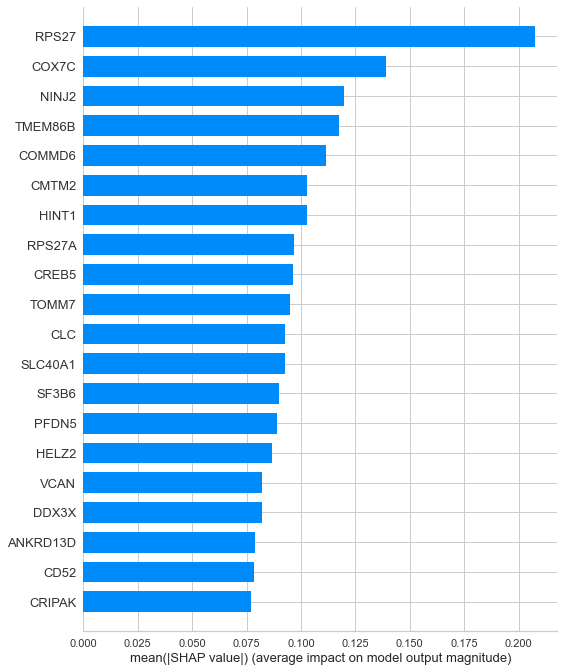

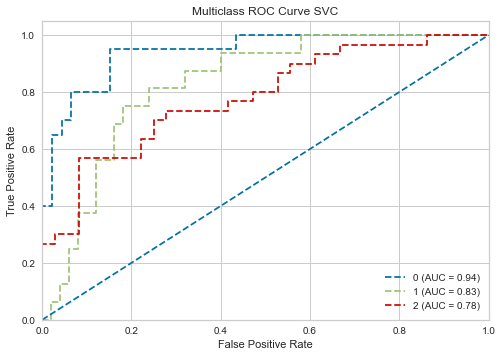

In [14]:
# training the svm model hypertuned parameters

print('Support vector classifier')
svc=SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True,kernel='poly',C= 50)
svc.fit(X_train_embsvc,Y_train_embsvc)
print(svc.score(X_train_embsvc,Y_train_embsvc))
print('SVC','\n',classification_report(Y_test,svc.predict(X_test_embsvc)))
print(confusion_matrix(Y_test,svc.predict(X_test_embsvc)))
print(f1_score(Y_test,svc.predict(X_test_embsvc),average="weighted"))
print(roc_auc_score(Y_test,svc.predict_proba(X_test_embsvc),multi_class='ovr',average='weighted'))
print('Balance_accuracy_score:-',balanced_accuracy_score(Y_test,svc.predict(X_test_embsvc)))

import shap
svm_explainer = shap.KernelExplainer(svc.predict,X_test_embsvc)
svm_shap_values = svm_explainer.shap_values(X_test_embsvc)
shap.summary_plot(svm_shap_values,X_test_embsvc,plot_type='bar')

pred_prob = svc.predict_proba(X_test_embsvc)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize y values
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# ROC curve for classes
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_class = y_test_binarized.shape[1]
classes = np.unique(Y_test)


for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotting
    plt.plot(fpr[i], tpr[i], linestyle='--', label='%s (AUC = %0.2f)'%(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC Curve SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()




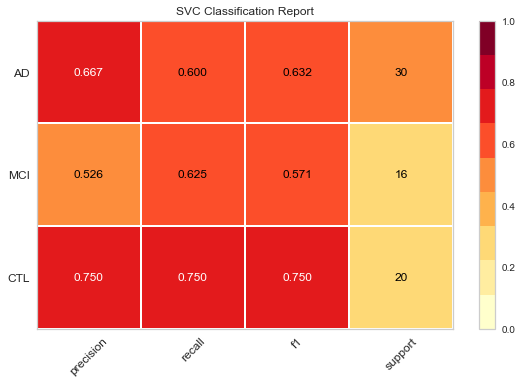

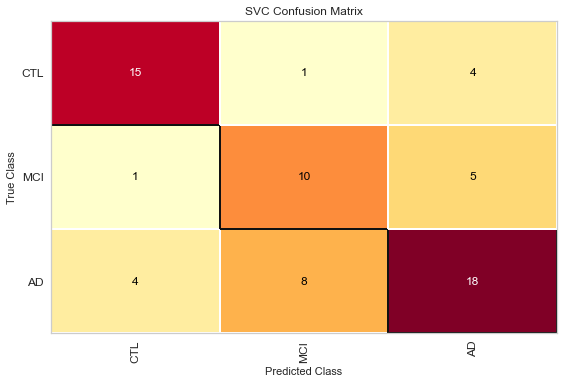

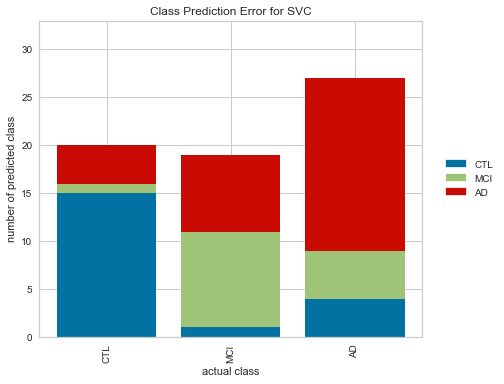

ClassPredictionError(ax=<AxesSubplot:title={'center':'Class Prediction Error for SVC'}, xlabel='actual class', ylabel='number of predicted class'>,
                     classes=['CTL', 'MCI', 'AD'],
                     estimator=SVC(C=50, break_ties=True, kernel='poly',
                                   probability=True, random_state=45))

In [92]:
# plotting through yellow brick classifier

# Specify the target classes
classes = ['CTL','MCI','AD']

model = SVC(decision_function_shape='ovr',random_state=45,break_ties=True,probability=True,C=50,kernel='poly')
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train_embsvc, Y_train_embsvc)        # Fit the visualizer and the model
visualizer.score(X_test_embsvc, Y_test)        # Evaluate the model on the test data
visualizer.show(cmap='green')

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_embsvc, Y_train_embsvc)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_embsvc, Y_test)

# How did we do?
cm.show()

# class prediction error

class_prediction_error(
    model,
    X_train_embsvc, Y_train_embsvc, X_test_embsvc, Y_test,
    classes=classes
)

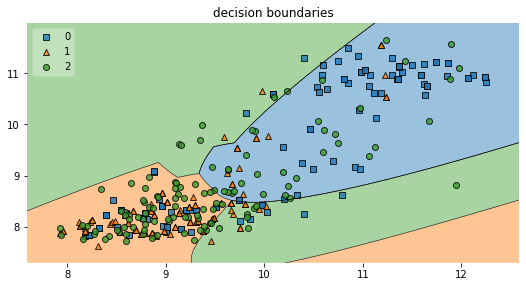

In [168]:
x_plot = X_train_embsvc[['RPS27', 'COMMD6']].values  # Convert DataFrame to NumPy array
y_plot = Y_train_embsvc.values  # Convert Series to NumPy array

gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(30,15))
svc.fit(x_plot, y_plot)

grd = (2, 2)  # Define the grid coordinates

ax = plt.subplot(gs[grd[0], grd[1]])  # Access grid coordinates using grd
fig = plot_decision_regions(X=x_plot, y=y_plot, clf=svc, legend=2,zoom_factor=3.0)
plt.title('decision boundaries')
plt.show()
